In [25]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/Stock/IBMStockData.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()
#spark = pyspark.sql.SparkSession.builder.master("local").appName("StockMarket").config("spark.executor.memory", "6gb").getOrCreate()
#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)

In [26]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
data = df.select('Open','High','Low','Volume','Close').toPandas()
print(data)
data['Close'] = data['Close'].shift(-30,fill_value= 0)
data.drop(data.tail(30).index,inplace=True)
print(data)
dataset = data.to_numpy()

          Open    High     Low  Volume   Close
0       112.28  112.28  112.28     120  112.28
1       112.53  112.70  112.28  134096  112.30
2       112.28  112.36  112.15   20521  112.17
3       112.17  112.36  112.17   20044  112.33
4       112.32  112.36  112.12   21591  112.25
...        ...     ...     ...     ...     ...
427619  125.92  126.26  125.91   48228  126.22
427620  126.22  126.41  126.22   44881  126.41
427621  126.42  126.50  126.35   44224  126.48
427622  126.49  126.60  126.44   59030  126.59
427623  126.59  126.59  126.25  148971  126.25

[427624 rows x 5 columns]
            Open    High     Low  Volume   Close
0       112.2800  112.28  112.28     120  112.35
1       112.5300  112.70  112.28  134096  112.20
2       112.2800  112.36  112.15   20521  112.21
3       112.1700  112.36  112.17   20044  112.02
4       112.3200  112.36  112.12   21591  112.20
...          ...     ...     ...     ...     ...
427589  126.8300  126.88  126.83    5938  126.22
427590  126.8500 

In [27]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Create the scaled training data set and test data set
train_data = dataset[0:training_data_len]
test_data = dataset[training_data_len :]

print(train_data[0], len(train_data))
print('-------------')
print(test_data[0], len(test_data))


#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print(scaled_train_data[0])
print('-------------')
print(scaled_test_data[0])

[112.28 112.28 112.28 120.   112.35] 342076
-------------
[ 131.86  131.88  131.85 6556.    132.03] 85518
[2.29371079e-01 2.28814922e-01 2.30633237e-01 5.44928034e-06
 2.30447377e-01]
-------------
[0.61990607 0.61720528 0.6267456  0.00260608 0.62246679]


In [28]:
xtrain = scaled_train_data[:, 0:-1]
ytrain = scaled_train_data[:, -1:]

xtest = scaled_test_data[:, 0:-1]
ytest = scaled_test_data[:, -1:]

print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (342076, 4)
xtest shape = (85518, 4)
ytrain shape = (342076, 1)
ytest shape = (85518, 1)


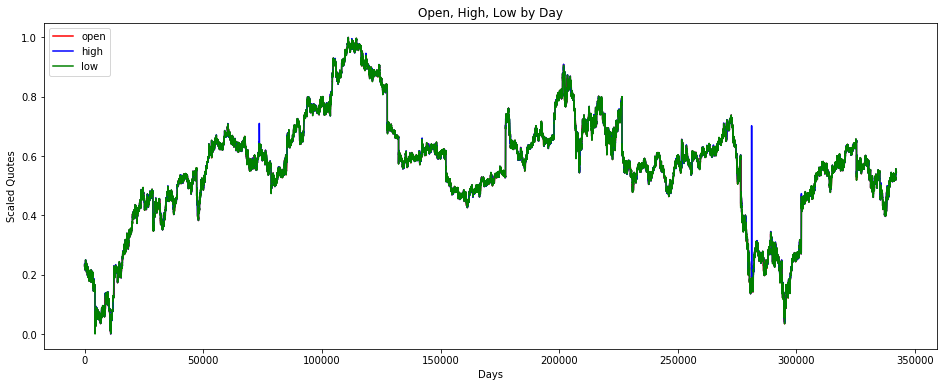

In [29]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

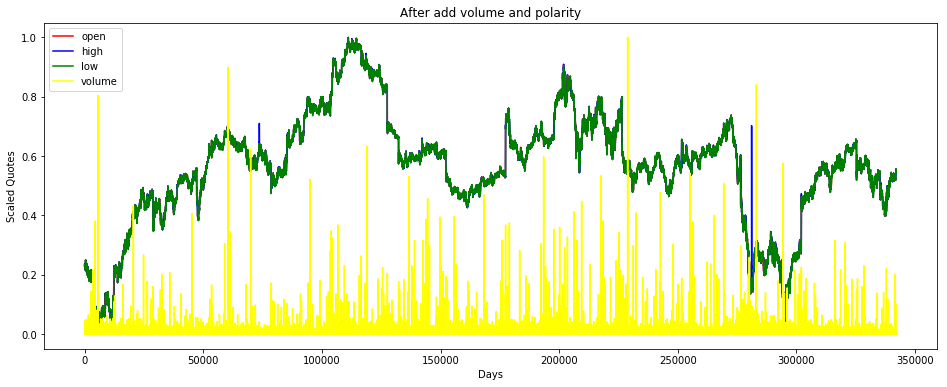

In [30]:
#volume and Polarity are very noisy
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='yellow', label='volume')
#plt.plot(xtrain[:,4],color='purple', label='Polarity')
plt.legend(loc = 'upper left')
plt.title('After add volume and polarity')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [31]:
from keras import models, layers
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,4)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(xtrain.shape)
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

loss = model.fit(xtrain, ytrain, batch_size=128, epochs=100)

(342076, 4)
The shape of xtrain is (342076, 1, 4): 
The shape of xtest is (85518, 1, 4): 
Epoch 1/100
342076/342076 [==============================] - 20s 58us/step - loss: 0.0164
Epoch 2/100
342076/342076 [==============================] - 13s 37us/step - loss: 1.6582e-04
Epoch 3/100
342076/342076 [==============================] - 12s 36us/step - loss: 1.2396e-04
Epoch 4/100
342076/342076 [==============================] - 13s 38us/step - loss: 9.5217e-05
Epoch 5/100
342076/342076 [==============================] - 12s 34us/step - loss: 7.9625e-05
Epoch 6/100
342076/342076 [==============================] - 13s 37us/step - loss: 7.1982e-05
Epoch 7/100
342076/342076 [==============================] - 12s 35us/step - loss: 6.7714e-05
Epoch 8/100
342076/342076 [==============================] - 12s 36us/step - loss: 6.5054e-05
Epoch 9/100
342076/342076 [==============================] - 12s 35us/step - loss: 6.3317e-05
Epoch 10/100
342076/342076 [==============================] - 12s 36

342076/342076 [==============================] - 8s 25us/step - loss: 5.5740e-05
Epoch 87/100
342076/342076 [==============================] - 9s 27us/step - loss: 5.5632e-05
Epoch 88/100
342076/342076 [==============================] - 9s 26us/step - loss: 5.5658e-05
Epoch 89/100
342076/342076 [==============================] - 9s 28us/step - loss: 5.5461e-05
Epoch 90/100
342076/342076 [==============================] - 9s 27us/step - loss: 5.5541e-05
Epoch 91/100
342076/342076 [==============================] - 9s 26us/step - loss: 5.5416e-05
Epoch 92/100
342076/342076 [==============================] - 9s 27us/step - loss: 5.5490e-05
Epoch 93/100
342076/342076 [==============================] - 9s 27us/step - loss: 5.5612e-05
Epoch 94/100
342076/342076 [==============================] - 9s 27us/step - loss: 5.5425e-05
Epoch 95/100
342076/342076 [==============================] - 9s 25us/step - loss: 5.5339e-05
Epoch 96/100
342076/342076 [==============================] - 9s 25us/ste

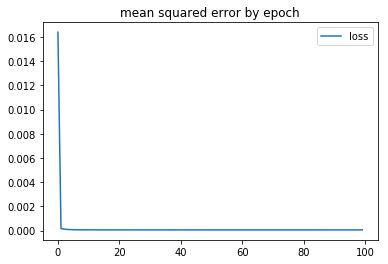

In [32]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [33]:
#Getting the models predicted price values
predictions = model.predict(xtest) 
print(predictions)

[[0.6142604 ]
 [0.61455774]
 [0.6140523 ]
 ...
 [0.53838444]
 [0.5390102 ]
 [0.53810453]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


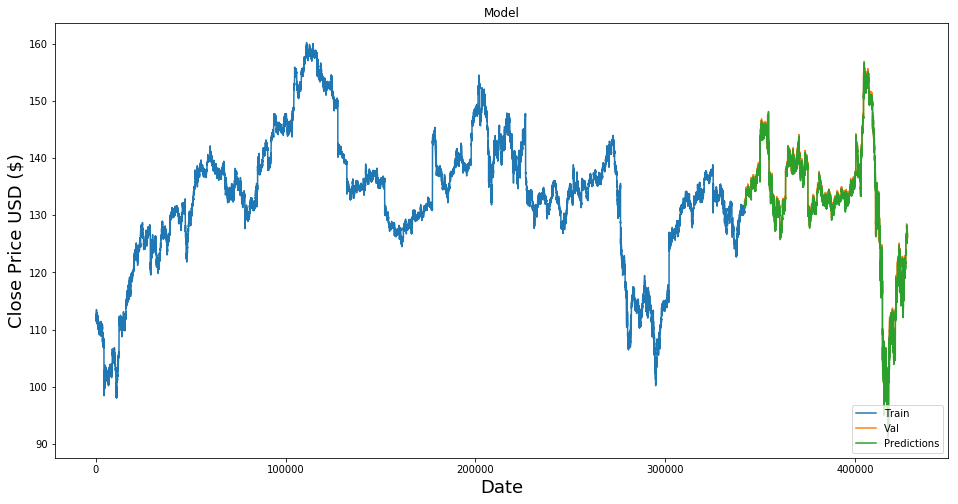

In [34]:
#Undo scaling, show real prediction
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 5) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]


train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [35]:
#Show the valid and predicted prices
valid

,Open,High,Low,Volume,Close,Predictions
342076,131.8600,131.88,131.85,6556,132.03,131.487327
342077,131.8700,131.87,131.83,4680,132.05,131.506957
342078,131.8300,131.85,131.79,2595,132.06,131.473592
342079,131.8200,131.82,131.78,2574,132.06,131.456815
342080,131.8000,131.84,131.80,1242,132.08,131.428652
...,...,...,...,...,...,...
427589,126.8300,126.88,126.83,5938,126.22,126.427553
427590,126.8500,126.93,126.82,4763,126.41,126.473744
427591,126.8666,126.90,126.83,6992,126.48,126.478757
427592,126.8900,126.89,126.80,5237,126.59,126.520065


In [36]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
from pyspark.ml.evaluation import RegressionEvaluator

df = valid[['Predictions', 'Close']]
print(df)
df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="rmse")
rmse = rmse_evaluator.evaluate(df_predictions)

mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mse")
mse = mse_evaluator.evaluate(df_predictions)

mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mae")
mae = mae_evaluator.evaluate(df_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Square Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

        Predictions   Close
342076   131.487327  132.03
342077   131.506957  132.05
342078   131.473592  132.06
342079   131.456815  132.06
342080   131.428652  132.08
...             ...     ...
427589   126.427553  126.22
427590   126.473744  126.41
427591   126.478757  126.48
427592   126.520065  126.59
427593   126.460280  126.25

[85518 rows x 2 columns]
Root Mean Squared Error (RMSE) on test data = 0.879781
Mean Square Error (MSE) on test data = 0.774015
Mean Absolute Error (MAE) on test data = 0.583203
